# setup

In [1]:
from teren import utils as tu
from teren import dir_act_utils as dau
from transformer_lens import HookedTransformer
from teren.typing import *
import torch

device = tu.get_device_str()
print(f"{device=}")

device='cuda'


In [2]:
SEQ_LEN = 10
INFERENCE_TOKENS = 25_000
SEED = 1
tu.setup_determinism(SEED)
INFERENCE_BATCH_SIZE = INFERENCE_TOKENS // SEQ_LEN
print(f"{INFERENCE_BATCH_SIZE=}")
N_PROMPTS = 100
LAYER_FRAC = 0.5

INFERENCE_BATCH_SIZE=2500


In [3]:
MODEL_NAME = "gpt2-small"
# MODEL_NAME = "google/gemma-2-2b"

In [4]:
# model = HookedTransformer.from_pretrained("gpt2-small", device=device)
model = HookedTransformer.from_pretrained(MODEL_NAME, device=device)
n_layers = model.cfg.n_layers
d_model = model.cfg.d_model
layer = round(LAYER_FRAC * (model.cfg.n_layers - 1))
layer

Loaded pretrained model gpt2-small into HookedTransformer


6

In [5]:
input_ids = dau.get_input_ids(
    chunk=0, seq_len=SEQ_LEN, n_prompts=N_PROMPTS, tokenizer=model.tokenizer
)
input_ids.shape

torch.Size([100, 10])

In [10]:
clean_resid_acts = model(input_ids, stop_at_layer=layer)
clean_resid_acts.shape

torch.Size([100, 10, 768])

In [23]:
clean_out = model(input_ids[:-1], stop_at_layer=n_layers)[:, -1].cpu()
clean_out.shape

torch.Size([99, 768])

In [24]:
import matplotlib.pyplot as plt

In [37]:
N_STEPS = 11
pert_out = torch.zeros(N_STEPS, N_PROMPTS - 1, d_model)
for i, step in enumerate(torch.linspace(1, 0, N_STEPS)):
    resid_acts_a = clean_resid_acts[:-1]
    resid_acts_a_last = resid_acts_a[:, -1]
    resid_acts_b = clean_resid_acts[1:]
    resid_acts_b_last = resid_acts_b[:, -1]
    pert_resid_acts = resid_acts_a.clone()
    pert_resid_acts[:, -1] = step * resid_acts_a_last + (1 - step) * resid_acts_b_last
    pert_out[i] = model(
        pert_resid_acts,
        start_at_layer=layer,
        stop_at_layer=n_layers,
    )[:, -1]
pert_out.shape

torch.Size([11, 99, 768])

In [38]:
norms = torch.linalg.norm(pert_out - clean_out, dim=-1)
norms.shape

torch.Size([11, 99])

In [39]:
norms.isfinite().all()

tensor(True)

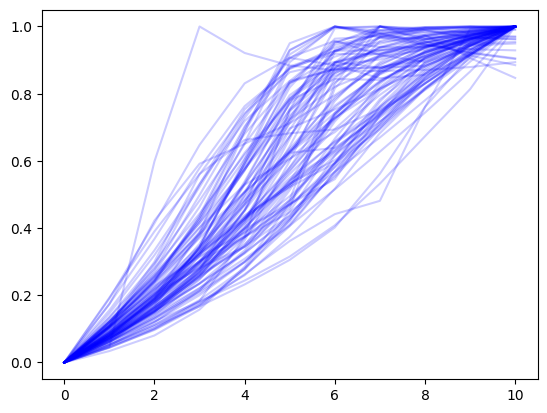

In [42]:
norms_max = norms.max(dim=0).values
norms_mask = norms_max > 30
plt.plot(norms[:, norms_mask] / norms_max[norms_mask], alpha=0.2, color="blue")